In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Loading the dataset

In [3]:
train_df = pd.read_csv('Google_Stock_Price_Train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [4]:
test_df = pd.read_csv('Google_Stock_Price_Test.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


#### Choosing column 'open' for predicition

In [5]:
train = train_df.loc[:,["Open"]].values
train.shape

(1258, 1)

### Feature Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [7]:
train_scaled = scaler.fit_transform(train)

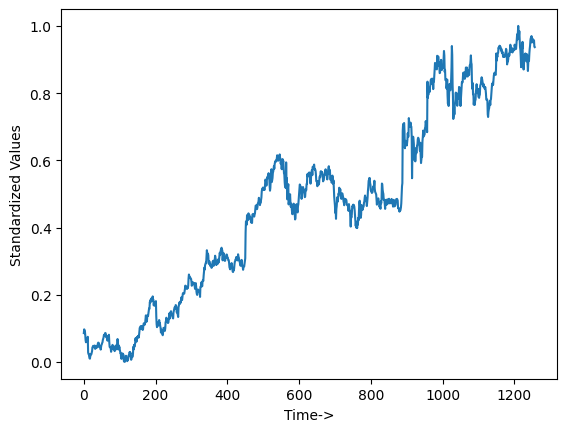

In [8]:
plt.plot(train_scaled)
plt.ylabel("Standardized Values")
plt.xlabel("Time->")
plt.show()

### Create data structure to train model  
Taking reference of past 60 days to predict future stock price  
x_train will have data of 60 days prior to current date and y_train will have price on current date

In [9]:
x_train = []
y_train = []
time = 60
for i in range(60,train_scaled.shape[0]):
    x_train.append(train_scaled[i-60:i,0])
    y_train.append(train_scaled[i,0])
x_train = np.array(x_train)
y_train = np.array(y_train)

In [10]:
x_train.shape,y_train.shape

((1198, 60), (1198,))

In [11]:
x_train = np.reshape(x_train,newshape=(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1198, 60, 1)

### Build model

In [12]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,Dropout

In [22]:
model = Sequential()

model.add(SimpleRNN(units=50,activation = "tanh", return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50,activation = "tanh", return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50,activation = "tanh", return_sequences = True))
model.add(Dropout(0.2))

model.add(SimpleRNN(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

In [24]:
model.fit(x_train,y_train,epochs=50,batch_size=30,validation_split=0.05)

Epoch 1/50
38/38 [==============================] - 1s 24ms/step - loss: 0.0100 - val_loss: 0.0073
Epoch 2/50
38/38 [==============================] - 1s 25ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 3/50
38/38 [==============================] - 1s 25ms/step - loss: 0.0095 - val_loss: 5.7505e-04
Epoch 4/50
38/38 [==============================] - 1s 25ms/step - loss: 0.0092 - val_loss: 0.0018
Epoch 5/50
38/38 [==============================] - 1s 25ms/step - loss: 0.0076 - val_loss: 0.0031
Epoch 6/50
38/38 [==============================] - 1s 24ms/step - loss: 0.0072 - val_loss: 5.3218e-04
Epoch 7/50
38/38 [==============================] - 1s 24ms/step - loss: 0.0072 - val_loss: 0.0040
Epoch 8/50
38/38 [==============================] - 1s 25ms/step - loss: 0.0073 - val_loss: 0.0035
Epoch 9/50
38/38 [==============================] - 1s 25ms/step - loss: 0.0064 - val_loss: 0.0020
Epoch 10/50
38/38 [==============================] - 1s 25ms/step - loss: 0.0060 - val_loss: 0.0013
E

### Prepare test dataset

In [25]:
data = pd.concat((train_df['Open'],test_df['Open']),axis=0)

In [26]:
test_input = data.iloc[len(data) - len(test_df) - time : ].values
test_input.shape

(80,)

In [27]:
test_input = test_input.reshape(-1,1)
test_input.shape

(80, 1)

In [28]:
test_scaled = scaler.transform(test_input)

#### Create test data set

In [29]:
x_test = []
for i in range(time,test_scaled.shape[0]):
    x_test.append(test_scaled[i - time: i,0 ])
x_test = np.array(x_test)
x_test.shape

(20, 60)

In [30]:
x_test = np.reshape(x_test,newshape=(x_test.shape[0],x_test.shape[1],1))
x_test.shape

(20, 60, 1)

In [31]:
y_test = test_df.loc[:,"Open"].values

### Model Prediction

In [32]:
y_pred = model.predict(x_test)

1/1 [==============================] - 0s 364ms/step


In [33]:
y_pred = scaler.inverse_transform(y_pred)

In [34]:
output = model.evaluate(x=x_test,y=y_test)

1/1 [==============================] - 0s 367ms/step - loss: 650732.0625


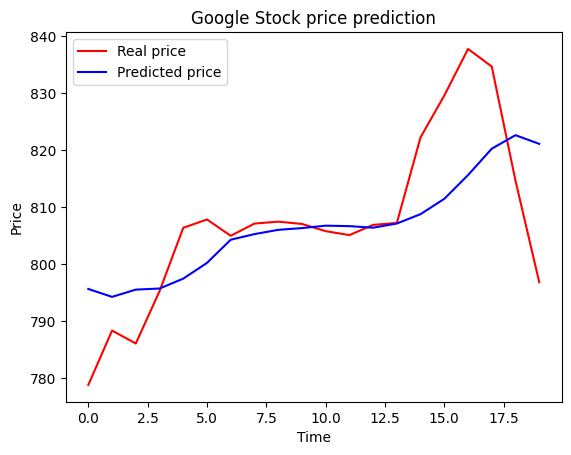

In [35]:
plt.plot(y_test, color = 'red', label = 'Real price')
plt.plot(y_pred, color = 'blue', label = 'Predicted price')

plt.title('Google Stock price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()